In [147]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import precision_score,f1_score
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from xgboost import XGBClassifier
from xgboost import plot_importance
import pickle
from sklearn.metrics import confusion_matrix
from oversampler_funtion import over_sampler
xgb.__version__

'1.6.0'

In [4]:
# cleaned data is posted on drive to pull feel free to use public link
url = 'https://drive.google.com/file/d/1zA-C6m7Rv9y051iVr8voieRRm-CnnzA1/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path)
df.head()

,unique_fire_identifier,lattitude,longitude,acres_burned,fire_cause,incident_name,IsFSAssisted,origin_county,state,year,...,area (acres),population,d0,d1,d2,d3,d4,DSCI_avg,DSCI_summed,precipitation(in)
0,2003-WYCMX-200237,-105.563067,44.603340,139.091837,Unknown,SCHWARTZ,1.0,Campbell,WY,2003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2004-CABDU-006784,-117.076679,34.733894,1906.698008,Unknown,MENTONE,1.0,San Bernardino,CA,2004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2008-IDGBK-000002,-116.216680,43.666673,685.728842,Unknown,NIFC RAMP SUPPORT,1.0,Ada,ID,2008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2008-IDCTF-008902,-111.426912,42.096336,20.000000,Unknown,St. Charles RX,0.0,Bear Lake,ID,2008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2008-AZPNF-000975,-112.072414,34.598306,77.946287,Unknown,Mingus/Cherry Rx,0.0,Yavapai,AZ,2008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# prepping original data to dummify
df_clean = df.fillna(0)
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical = ['object']
numdf = df_clean.copy().select_dtypes(include=numerics)
catdf = df_clean.copy().select_dtypes(include=categorical)
catdf.drop(columns=['unique_fire_identifier','incident_name'],inplace=True)
catdf.head()

,fire_cause,origin_county,state
0,Unknown,Campbell,WY
1,Unknown,San Bernardino,CA
2,Unknown,Ada,ID
3,Unknown,Bear Lake,ID
4,Unknown,Yavapai,AZ


In [6]:
# will dummify these to pass into models
dummified_1 = pd.get_dummies(data=catdf,drop_first=True) 
dummified_1 = pd.concat([numdf,dummified_1],axis=1)
print(dummified_1.shape)
dummified_1.head()

(213787, 1512)


,lattitude,longitude,acres_burned,IsFSAssisted,year,month,value,anomaly,area (acres),population,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,-105.563067,44.603340,139.091837,1.0,2003,1,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,-117.076679,34.733894,1906.698008,1.0,2004,7,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,-116.216680,43.666673,685.728842,1.0,2008,7,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,-111.426912,42.096336,20.000000,0.0,2008,9,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,-112.072414,34.598306,77.946287,0.0,2008,10,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [152]:
# code block created by David Coons
conditions = [df['acres_burned'] <= .25,
             (df['acres_burned'] > .25) & (df['acres_burned'] <= 9.9),
             (df['acres_burned'] > 9.9) & (df['acres_burned'] <= 99.99),
             (df['acres_burned'] > 99.99) & (df['acres_burned'] <= 299),
             (df['acres_burned'] > 299) & (df['acres_burned'] <= 999),
             (df['acres_burned'] > 999) & (df['acres_burned'] <= 5000),
             (df['acres_burned'] > 5000) & (df['acres_burned'] <= 9999),
             (df['acres_burned'] > 9999) & (df['acres_burned'] <= 49_999),
             (df['acres_burned'] > 49_999) & (df['acres_burned'] <= 100_000),
              (df['acres_burned'] > 100_000)]

# choices = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
choices = [0,1,2,3,4,5,6,7,8,9]

dummified_1['fire_class'] = np.select(conditions, choices, default = 0)
dummified_1['fire_class'].value_counts(normalize=False)

0    68563
1    48963
2    31458
4    22337
5    22108
3    18611
7      804
6      667
8      155
9      121
Name: fire_class, dtype: int64

In [9]:
# creating copy to pass along into X,y (in case of manipulation later)
model_1 = dummified_1.drop(columns='acres_burned')
model_1 = model_1.sort_values(by=['year','month'])

In [8]:
# prepping my training and testing batches double checking class balances
X = model_1.drop(columns = 'fire_class') 
y = model_1['fire_class']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    stratify=y,
                                                    shuffle=True,
                                                    random_state=42)
print(y_test.unique())
y_test.value_counts(normalize=True) # double checking that it was stratified 

[1 2 0 4 5 3 6 7 8 9]


0    0.321010
1    0.228769
2    0.147099
4    0.104477
5    0.103317
3    0.087058
7    0.003761
6    0.003218
8    0.000730
9    0.000561
Name: fire_class, dtype: float64

In [12]:
y_train.value_counts(normalize=True)

0    0.321005
1    0.228776
2    0.147100
4    0.104478
5    0.103305
3    0.087065
7    0.003761
6    0.003218
8    0.000723
9    0.000568
Name: fire_class, dtype: float64

In [36]:
# instantiating first model (most of these are defaults)
model = XGBClassifier(objective='multi:softmax',
                      seed=42,
                      n_estimators=10,
                      learning_rate=0.1,
                      booster='gbtree',
                      reg_alpha=0,
                      max_delta_step=0)
model.fit(X_train, y_train)

XGBClassifier(n_estimators=10, objective='multi:softprob', seed=42)

In [42]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
preds = model.predict(X_test)
from sklearn.metrics import confusion_matrix

# printing confusion matrix
cm = confusion_matrix(y_test, preds)
pd.DataFrame(cm)

Accuracy: 55.74%


,0,1,2,3,4,5,6,7,8,9
0,13219,2281,458,67,654,478,0,0,0,0
1,6402,4063,956,113,475,218,0,0,0,0
2,2079,1633,3589,95,423,43,0,0,0,0
3,1121,871,937,1234,464,26,0,0,0,0
4,850,665,441,64,3468,96,0,0,0,0
5,531,330,262,32,148,4219,0,0,0,0
6,110,34,7,0,13,8,0,0,0,0
7,149,20,5,3,13,11,0,0,0,0
8,26,1,1,0,3,8,0,0,0,0
9,17,5,1,0,2,5,0,0,0,0


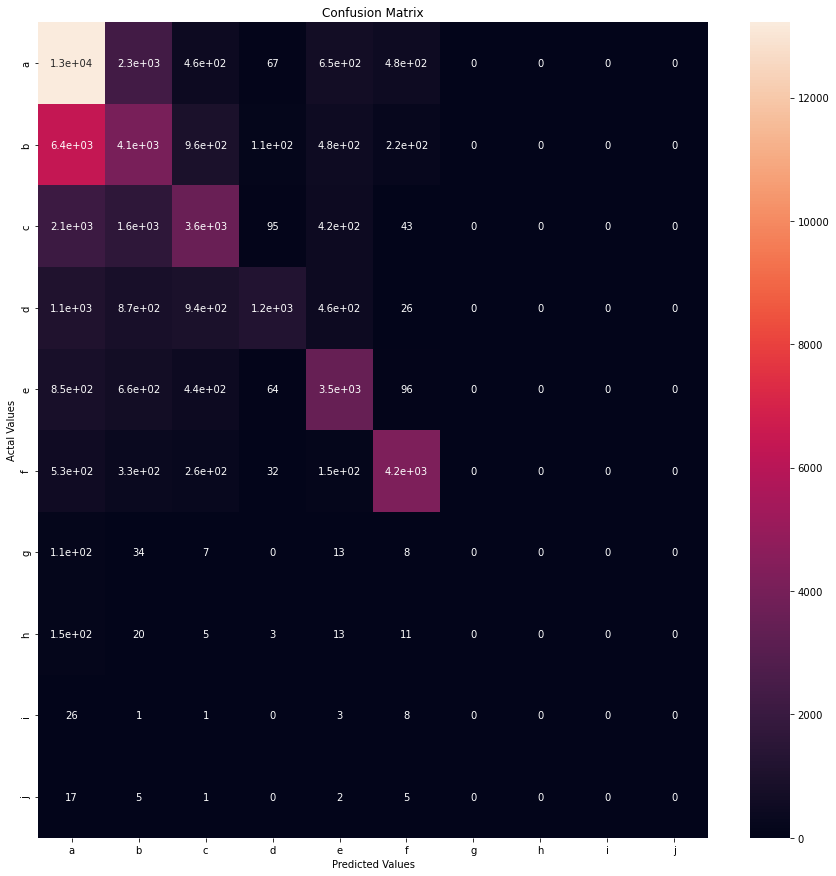

In [43]:
# creating nice plot of conf matrix
cm_df = pd.DataFrame(cm,
                     index = ['a','b','c','d','e','f','g','h','i','j'], 
                     columns = ['a','b','c','d','e','f','g','h','i','j'])

#Plotting the confusion matrix
plt.figure(figsize=(15,15))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [44]:
# Average is assigned micro
precisionScore_sklearn_microavg = precision_score(y_test, y_pred, average='micro', zero_division=0)

# Average is assigned macro
precisionScore_sklearn_macroavg = precision_score(y_test, y_pred, average='macro')
f1_score_sklearn_macro = f1_score(y_test, y_pred, average='macro')
f1_score_sklearn_micro = f1_score(y_test, y_pred, average='micro')

# Printing micro and macro average precision score
print(precisionScore_sklearn_microavg, precisionScore_sklearn_macroavg)
f1_score_sklearn_micro,f1_score_sklearn_macro

0.5574120156416636 0.3693996579838004


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.5574120156416636, 0.33005554149202626)

---
### First Tuning based on best performing Random Forest Model Parameters
- n_estimators to 20
- Max_depth to 2

In [11]:
model2 = XGBClassifier(objective='multi:softmax',
                       seed=42,
                       n_estimators=20,
                       max_depth=2)
model2.fit(X_train, y_train)

In [13]:
# make predictions for test data
y_pred = model2.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
preds = model2.predict(X_test)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, preds)
pd.DataFrame(cm)

Accuracy: 53.23%


,0,1,2,3,4,5,6,7,8,9
0,13504,2126,474,109,244,700,0,0,0,0
1,6916,3735,969,129,171,307,0,0,0,0
2,2275,1761,3453,127,179,67,0,0,0,0
3,1412,982,1052,885,291,31,0,0,0,0
4,983,834,549,85,3032,101,0,0,0,0
5,582,341,287,6,467,3839,0,0,0,0
6,112,33,7,0,8,12,0,0,0,0
7,151,22,6,3,6,13,0,0,0,0
8,26,2,1,0,2,8,0,0,0,0
9,19,3,1,1,1,5,0,0,0,0


In [14]:
# Average is assigned micro
precisionScore_sklearn_microavg = precision_score(y_test, y_pred, average='micro', zero_division='warn')
precisionScore_sklearn_macroavg = precision_score(y_test, y_pred, average='macro',zero_division='warn')

# f1_score
f1_score_sklearn_macro = f1_score(y_test, y_pred, average='macro')
f1_score_sklearn_micro = f1_score(y_test, y_pred, average='micro')

# micro/macro average precision/f1 scores
print(precisionScore_sklearn_microavg, precisionScore_sklearn_macroavg)
f1_score_sklearn_micro,f1_score_sklearn_macro

0.5322656089209872 0.3509454541309015


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.5322656089209872, 0.3062081188012062)

### Second Tuning 
- n_estimators from 20 to 100 
- max_depth from 2 to 3

In [9]:
model3 = XGBClassifier(objective='multi:softmax',
                       seed=42,
                       n_estimators=100,
                       max_depth=3)

model3.fit(X_train, y_train)
# make predictions for test data
y_pred = model3.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
preds = model3.predict(X_test)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, preds)

pd.DataFrame(cm)

Accuracy: 60.10%


,0,1,2,3,4,5,6,7,8,9
0,14332,1868,334,105,279,238,0,1,0,0
1,6614,4474,640,168,198,131,0,2,0,0
2,2075,1838,3547,214,168,18,0,2,0,0
3,948,959,415,2027,278,25,0,1,0,0
4,905,705,242,189,3516,25,0,2,0,0
5,542,352,87,172,141,4219,0,9,0,0
6,104,38,2,6,12,6,0,4,0,0
7,122,44,3,4,11,9,0,8,0,0
8,25,4,1,0,2,7,0,0,0,0
9,13,8,1,0,1,4,0,3,0,0


### Third Iteration:
- n_estimators from 100 to 200

In [9]:
# fitting model with 200 estimators 
model4 = XGBClassifier(objective='multi:softmax',
                       seed=42,
                       n_estimators=200,
                       max_depth=3)
model4.fit(X_train, y_train)

In [10]:
# make predictions for test data and max_depth
y_pred = model4.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
preds = model4.predict(X_test)
# printing confusion matrix
cm = confusion_matrix(y_test, preds)
pd.DataFrame(cm)

Accuracy: 61.41%


,0,1,2,3,4,5,6,7,8,9
0,14345,1872,312,124,267,236,0,1,0,0
1,6388,4663,626,206,207,132,0,5,0,0
2,1886,1859,3674,268,151,21,0,3,0,0
3,915,890,351,2210,254,32,0,1,0,0
4,848,655,211,216,3612,40,0,2,0,0
5,502,339,66,157,145,4303,0,10,0,0
6,95,44,3,2,14,9,0,5,0,0
7,114,45,5,3,11,10,0,13,0,0
8,22,7,1,0,2,7,0,0,0,0
9,13,6,2,0,2,4,0,3,0,0


In [11]:
# Average is assigned micro
precisionScore_sklearn_microavg = precision_score(y_test, preds, average='micro', zero_division='warn')
precisionScore_sklearn_macroavg = precision_score(y_test, preds, average='macro',zero_division='warn')

# f1_score
f1_score_sklearn_macro = f1_score(y_test, preds, average='macro')
f1_score_sklearn_micro = f1_score(y_test, preds, average='micro')

# micro/macro average precision/f1 scores
print(precisionScore_sklearn_microavg, precisionScore_sklearn_macroavg)
f1_score_sklearn_micro,f1_score_sklearn_macro

0.6140662712593784 0.4387624827336042


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.6140662712593784, 0.3860870369178705)

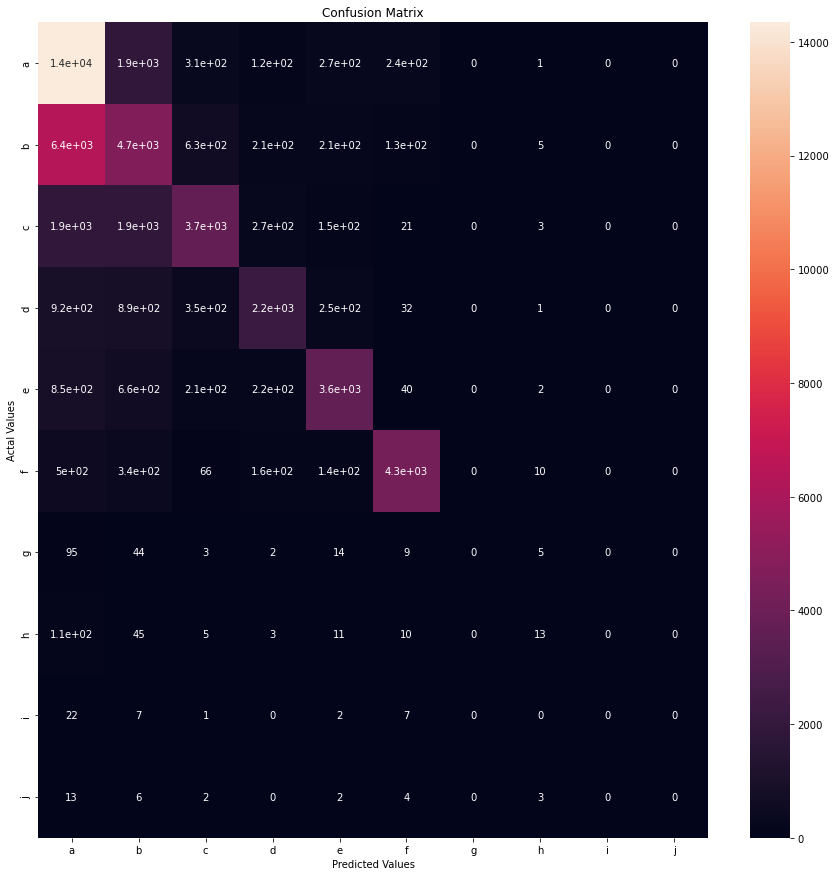

In [12]:
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['a','b','c','d','e','f','g','h','i','j'], 
                     columns = ['a','b','c','d','e','f','g','h','i','j'])

#Plotting the confusion matrix
plt.figure(figsize=(15,15))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [16]:
# fitting model with more decsion trees
model5 = XGBClassifier(objective='multi:softmax',seed=42,n_estimators=300,max_depth=3)
model5.fit(X_train, y_train)

# make predictions for test data
y_pred = model5.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
preds = model5.predict(X_test)

cm = confusion_matrix(y_test, preds)
# Average is assigned micro
precisionScore_sklearn_microavg = precision_score(y_test, preds, average='micro', zero_division='warn')
precisionScore_sklearn_macroavg = precision_score(y_test, preds, average='macro',zero_division='warn')

# f1_score
f1_score_sklearn_macro = f1_score(y_test, preds, average='macro')
f1_score_sklearn_micro = f1_score(y_test, preds, average='micro')

# micro/macro average precision/f1 scores
print(precisionScore_sklearn_microavg, precisionScore_sklearn_macroavg)
# printing confusion matrix
pd.DataFrame(cm)

Accuracy: 62.11%
0.6210638576533762 0.4389637378084167


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,0,1,2,3,4,5,6,7,8,9
0,14409,1854,297,119,257,219,0,2,0,0
1,6345,4698,625,221,207,126,0,5,0,0
2,1836,1840,3715,294,148,26,0,3,0,0
3,827,877,342,2327,238,41,0,1,0,0
4,822,626,207,221,3656,49,0,3,0,0
5,458,327,77,122,151,4376,0,11,0,0
6,89,45,5,2,13,13,0,5,0,0
7,110,48,7,3,10,10,0,13,0,0
8,22,6,1,0,2,6,0,2,0,0
9,12,5,2,0,4,4,0,3,0,0


In [18]:
# forgot to print f1_scores above
print('f1_scores (micro,macro): ',f1_score_sklearn_micro,f1_score_sklearn_macro)

f1_scores (micro,macro):  0.6210638576533762 0.3909899241251203


In [9]:
### EDIT ##
model6 = XGBClassifier(objective='multi:softmax',seed=42,n_estimators=400,max_depth=4)
model6.fit(X_train, y_train)

# predictions for test data 
y_pred = model6.predict(X_test)
preds = model6.predict(X_test)

predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# storing confusion matrix
cm = confusion_matrix(y_test, preds)
# Average is assigned micro
precisionScore_sklearn_microavg = precision_score(y_test, preds, average='micro', zero_division='warn')
precisionScore_sklearn_macroavg = precision_score(y_test, preds, average='macro',zero_division='warn')

# f1_score
f1_score_sklearn_macro = f1_score(y_test, preds, average='macro')
f1_score_sklearn_micro = f1_score(y_test, preds, average='micro')

# micro/macro average precision/f1 scores
print('precision score (micro/macro): ',precisionScore_sklearn_microavg, precisionScore_sklearn_macroavg)
print('f1_scores (micro,macro): ',f1_score_sklearn_micro,f1_score_sklearn_macro)

# looking at confusion matrix
pd.DataFrame(cm)

Accuracy: 64.13%
precision score (micro/macro):  0.6413269219974929 0.4485397556303868
f1_scores (micro,macro):  0.6413269219974929 0.405556667638009


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,0,1,2,3,4,5,6,7,8,9
0,14540,1833,277,133,181,191,0,2,0,0
1,6215,4857,592,227,217,112,1,6,0,0
2,1687,1795,3951,256,137,32,0,3,0,1
3,713,770,300,2615,212,42,0,0,0,1
4,715,597,205,167,3818,78,1,3,0,0
5,427,287,80,71,161,4484,1,11,0,0
6,80,37,11,3,15,18,0,8,0,0
7,101,44,12,2,14,15,1,12,0,0
8,20,5,1,0,3,7,0,3,0,0
9,14,4,4,0,2,3,0,3,0,0


---
### Fitting on diff class imbalances (nulls still imputed with 0s)

In [35]:
# oversampling minority class to match class size of 5
over_class5 = over_sampler(model_1,'fire_class')
print(over_class5.shape[0])
over_class5['fire_class'].value_counts()

What class do we want from needs to be an INT(our case ~ 0-9)? 5


303836


0    68627
1    48909
2    31448
4    22336
3    22086
5    22086
8    22086
7    22086
6    22086
9    22086
Name: fire_class, dtype: int64

In [36]:
# looking at how much needs to be stripped from the oversampled df
diff = np.abs(df.shape[0]-over_class5.shape[0])
print('original',df.shape[0])
print('difference: ',diff)
X = over_class5.drop(columns='fire_class')
y = over_class5['fire_class']
# removing excessive data from the original df
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=diff,
                                                    random_state = 5, 
                                                    stratify = y)
print('Back to original dataframe: ',X_train.shape[0])

# actually removing the 
X_train, X_test, y_train, y_test = train_test_split(X_train,
                                                    y_train, 
                                                    random_state = 5, 
                                                    stratify = y_train)

original 213787
difference:  90049
Back to original dataframe:  213787


In [37]:
# filling model on oversample 5 dataset
model7 = XGBClassifier(objective='multi:softmax',
                       seed=42,
                       n_estimators=80,
                       max_depth=4)
model7.fit(X_train, y_train)

# exporting model to the cloud 
bucket = storage_client.bucket('bucket_training_dsi_demo')

### EDIT ##
blob = bucket.blob('xgbmodel7.pickle')
pickle_out = pickle.dumps(model7)
blob.upload_from_string(pickle_out)

### EDIT make predictions for test data ##
y_pred = model7.predict(X_test)
preds = model7.predict(X_test)

predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# storing confusion matrix
cm = confusion_matrix(y_test, preds)

# Average is assigned micro
precisionScore_sklearn_microavg = precision_score(y_test, preds, average='micro', zero_division='warn')
precisionScore_sklearn_macroavg = precision_score(y_test, preds, average='macro',zero_division='warn')

# f1_score
f1_score_sklearn_macro = f1_score(y_test, preds, average='macro')
f1_score_sklearn_micro = f1_score(y_test, preds, average='micro')

# micro/macro average precision/f1 scores
print('precision score (micro/macro): ',precisionScore_sklearn_microavg, precisionScore_sklearn_macroavg)
print('f1_scores (micro,macro): ',f1_score_sklearn_micro,f1_score_sklearn_macro)

# looking at confusion matrix
pd.DataFrame(cm)

Accuracy: 57.08%
precision score (micro/macro):  0.5708084644601193 0.6619085132724988
f1_scores (micro,macro):  0.5708084644601193 0.5786562658491233


,0,1,2,3,4,5,6,7,8,9
0,9881,1217,278,122,126,136,32,67,116,97
1,4475,2954,459,222,138,81,45,76,102,52
2,1273,1156,2586,240,93,31,39,43,56,15
3,674,639,228,2033,138,39,46,43,27,18
4,558,331,142,198,2498,36,56,52,33,25
5,317,195,36,97,80,2979,51,45,29,56
6,1703,364,119,73,92,118,952,158,245,61
7,1709,193,38,62,105,82,82,1101,349,164
8,774,0,0,0,49,132,0,101,2650,179
9,674,0,0,0,66,144,0,70,57,2874


In [12]:
# # oversampling minority class to match class size of 3
over_class3 = over_sampler(model_1,'fire_class')
print(over_class3.shape[0])
over_class3['fire_class'].value_counts()

# looking at how much I need to strip from the oversampled df
diff = np.abs(model_1.shape[0]-over_class3.shape[0])
print('original',model_1.shape[0])
print('difference: ',diff)

What class do we want from needs to be an INT(our case ~ 0-9)? 3


286471
original 213787
difference:  72684


In [13]:
# looking at how much needs to be stripped from the oversampled df
X = over_class3.drop(columns='fire_class')
y = over_class3['fire_class']
# removing excessive data from the original df
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=diff,
                                                    random_state = 5, 
                                                    stratify = y)
print('Back to original dataframe: ',X_train.shape[0])

# actually splitting data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X_train,
                                                    y_train, 
                                                    random_state = 5, 
                                                    stratify = y_train)

Back to original dataframe:  213787


In [15]:
# fitting model on final train test sets
model8 = XGBClassifier(objective='multi:softmax',seed=42,n_estimators=250,max_depth=4)
model8.fit(X_train, y_train)

# predictions for test data 
y_pred = model8.predict(X_test)
preds = model8.predict(X_test)

predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# storing confusion matrix
cm = confusion_matrix(y_test, preds)

# Average is assigned micro
precisionScore_sklearn_microavg = precision_score(y_test, preds, average='micro', zero_division='warn')
precisionScore_sklearn_macroavg = precision_score(y_test, preds, average='macro',zero_division='warn')

# f1_score
f1_score_sklearn_macro = f1_score(y_test, preds, average='macro')
f1_score_sklearn_micro = f1_score(y_test, preds, average='micro')

# micro/macro average precision/f1 scores
print('precision score (micro/macro): ',precisionScore_sklearn_microavg, precisionScore_sklearn_macroavg)
print('f1_scores (micro,macro): ',f1_score_sklearn_micro,f1_score_sklearn_macro)

# looking at confusion matrix
pd.DataFrame(cm)

Accuracy: 62.96%
precision score (micro/macro):  0.6295582539712238 0.7133941093837877
f1_scores (micro,macro):  0.6295582539712238 0.6495257225665949


,0,1,2,3,4,5,6,7,8,9
0,10540,1338,247,117,131,151,41,63,105,71
1,4560,3405,438,193,158,74,60,101,87,49
2,1283,1246,2843,196,85,41,48,66,46,13
3,524,502,208,1983,104,29,50,42,21,10
4,584,339,142,154,2732,47,55,54,28,32
5,295,187,45,53,86,3293,49,47,22,44
6,1297,259,75,32,55,109,1262,168,140,75
7,1324,108,18,35,77,100,87,1283,276,164
8,279,0,0,0,0,62,0,63,2978,91
9,116,0,0,0,0,28,0,0,0,3329


In [26]:
# use case example
over_class3 = over_sampler(model_1,'fire_class')
print(over_class3.shape[0])
over_class3['fire_class'].value_counts()
# looking at how much I need to strip from the oversampled df
diff = np.abs(model_1.shape[0]-over_class3.shape[0])
print('original',model_1.shape[0])
print('difference: ',diff)
# since this did not 
X = over_class3.drop(columns='fire_class')
y = over_class3['fire_class']
# removing excessive data from the original df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=diff,random_state = 5, stratify = y)
print('Back to original dataframe: ',X_train.shape[0])

# actually removing the 
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train, random_state = 5,   stratify = y_train)

### EDIT ##
model9 = XGBClassifier(objective='multi:softmax',seed=42,n_estimators=400,max_depth=4)
model9.fit(X_train, y_train)

What class do we want from needs to be an INT(our case ~ 0-9)? 3


286471
original 213787
difference:  72684
Back to original dataframe:  213787


In [27]:
# instantiating model
model9_pickled = xgb.XGBClassifier()
# loading it just ensuring it is able to be used after saving
model9_pickled.load_model('../../Viz/model10.json')

# predictions for test data 
y_pred = model9_pickled.predict(X_test)
preds = model9_pickled.predict(X_test)

predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# storing confusion matrix
cm = confusion_matrix(y_test, preds)

# Average is assigned micro
precisionScore_sklearn_microavg = precision_score(y_test, preds, average='micro', zero_division='warn')
precisionScore_sklearn_macroavg = precision_score(y_test, preds, average='macro',zero_division='warn')

# f1_score
f1_score_sklearn_macro = f1_score(y_test, preds, average='macro')
f1_score_sklearn_micro = f1_score(y_test, preds, average='micro')

# micro/macro average precision/f1 scores
print('precision score (micro/macro): ',precisionScore_sklearn_microavg, precisionScore_sklearn_macroavg)
print('f1_scores (micro,macro): ',f1_score_sklearn_micro,f1_score_sklearn_macro)

# looking at confusion matrix
pd.DataFrame(cm)

Accuracy: 70.38%
precision score (micro/macro):  0.7037626059460774 0.775093328709069
f1_scores (micro,macro):  0.7037626059460774 0.7480940386297454


,0,1,2,3,4,5,6,7,8,9
0,10443,1443,235,122,129,121,112,124,43,32
1,4171,3717,475,207,165,70,106,148,40,26
2,1072,1253,3033,182,95,38,80,92,19,3
3,401,451,192,2158,112,35,51,54,15,4
4,449,281,133,160,2900,78,80,68,13,5
5,235,160,39,52,98,3375,72,63,14,13
6,566,123,15,6,48,39,2485,156,31,3
7,559,78,0,20,32,35,94,2557,80,17
8,0,0,0,0,0,0,0,0,3473,0
9,0,0,0,0,0,0,0,0,0,3473


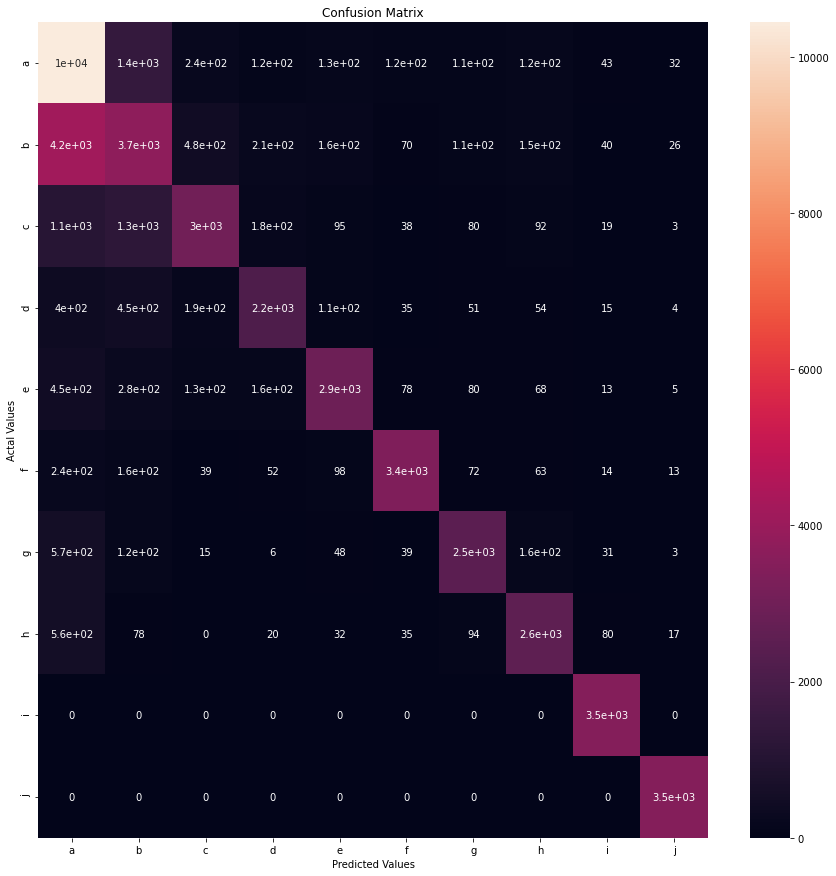

In [29]:
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['a','b','c','d','e','f','g','h','i','j'], 
                     columns = ['a','b','c','d','e','f','g','h','i','j'])

#Plotting the confusion matrix
plt.figure(figsize=(15,15))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

# Streamlit(Best Performing) Model  
Nulls Imputed Average, n_estimators = 400, & oversampling to match class 3

In [88]:
# cleaned data is posted on drive demo to pull 
url = 'https://drive.google.com/file/d/1K1hYkA9hXCM2XndZo2uuvX8H0N10pvv2/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df_imputed = pd.read_csv(path)
df_imputed.drop(columns='Unnamed: 0',inplace=True)
df_imputed.head()

,unique_fire_identifier,lattitude,longitude,acres_burned,fire_cause,incident_name,IsFSAssisted,origin_county,state,year,...,population,d0,d1,d2,d3,d4,DSCI_avg,DSCI_summed,precipitation(in),regions
0,2003-WYCMX-200237,-105.563067,44.603340,139.091837,Unknown,SCHWARTZ,1.0,Campbell,WY,2003,...,3.303917e+06,18.249151,14.653462,12.028498,11.200130,5.348644,184.442738,802.985483,0.049736,Mountain
1,2004-CABDU-006784,-117.076679,34.733894,1906.698008,Unknown,MENTONE,1.0,San Bernardino,CA,2004,...,3.680509e+07,12.676957,14.073960,14.320113,15.726569,9.183301,225.324333,972.517550,0.020251,Pacific
2,2008-IDGBK-000002,-116.216680,43.666673,685.728842,Unknown,NIFC RAMP SUPPORT,1.0,Ada,ID,2008,...,3.303917e+06,18.249151,14.653462,12.028498,11.200130,5.348644,184.442738,802.985483,0.049736,Mountain
3,2008-IDCTF-008902,-111.426912,42.096336,20.000000,Unknown,St. Charles RX,0.0,Bear Lake,ID,2008,...,3.303917e+06,18.249151,14.653462,12.028498,11.200130,5.348644,184.442738,802.985483,0.049736,Mountain
4,2008-AZPNF-000975,-112.072414,34.598306,77.946287,Unknown,Mingus/Cherry Rx,0.0,Yavapai,AZ,2008,...,3.303917e+06,18.249151,14.653462,12.028498,11.200130,5.348644,184.442738,802.985483,0.049736,Mountain


In [93]:
# prepping the df_imputed to be put into xgboost
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical = ['object']
numdf = df_imputed.copy().select_dtypes(include=numerics)
catdf = df_imputed.copy().select_dtypes(include=categorical)
catdf.drop(columns=['unique_fire_identifier','incident_name', 'fire_cause', 'regions'],inplace=True)
catdf.head()
# will dummify these features to obtain correlations  
dummified_imputed= pd.get_dummies(data=catdf,drop_first=True) 
whole_imputed = pd.concat([numdf,dummified_imputed],axis=1)
whole_imputed.drop(columns='acres_burned',inplace=True)
print(whole_imputed.shape)
whole_imputed.head()

(213787, 1509)


,lattitude,longitude,IsFSAssisted,year,month,value,anomaly,area (acres),population,d0,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,-105.563067,44.603340,1.0,2003,1,63.015560,2.637712,7.112131e+07,3.303917e+06,18.249151,...,0,0,0,0,0,0,0,0,0,1
1,-117.076679,34.733894,1.0,2004,7,67.565495,2.906169,1.254012e+08,3.680509e+07,12.676957,...,0,0,0,0,0,0,0,0,0,0
2,-116.216680,43.666673,1.0,2008,7,63.015560,2.637712,7.112131e+07,3.303917e+06,18.249151,...,0,0,0,0,0,0,0,0,0,0
3,-111.426912,42.096336,0.0,2008,9,63.015560,2.637712,7.112131e+07,3.303917e+06,18.249151,...,0,0,0,0,0,0,0,0,0,0
4,-112.072414,34.598306,0.0,2008,10,63.015560,2.637712,7.112131e+07,3.303917e+06,18.249151,...,0,0,0,0,0,0,0,0,0,0


In [100]:
# storing list to be used in streamlit app for filling in columns
with open('../../Viz/columns_list.pkl', 'wb') as pickle_out:
    columns = pickle.dump(X.columns.tolist(),pickle_out)


In [94]:
# use case example
over_class3 = over_sampler(whole_imputed,'fire_class')
print(over_class3.shape[0])
over_class3['fire_class'].value_counts()
# looking at how much I need to strip from the oversampled df
diff = np.abs(whole_imputed.shape[0]-over_class3.shape[0])
print('original',whole_imputed.shape[0])
print('difference: ',diff)
# since this did not 
X = over_class3.drop(columns='fire_class')
y = over_class3['fire_class']
# removing excessive data from the original df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=diff,random_state = 5, stratify = y)
print('Back to original dataframe: ',X_train.shape[0])

# actually removing the 
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train, random_state = 5,   stratify = y_train)

# fitting last model on oversampled data class size 3 with imputed nulls
model10_topickle = XGBClassifier(objective='multi:softmax',seed=42,n_estimators=400,max_depth=4)
model10_topickle.fit(X_train, y_train)

# save in JSON format in folder where streamlit app can be run
model10_topickle.save_model("../../Viz/model10.json")
# save in text format as well
model10_topickle.save_model("../../Viz/model10.txt")


# unpickling to ensure it is usable post saving process
model10_unpickled = xgb.XGBClassifier()
model10_unpickled.load_model("../../Viz/model10.json")

# predictions for test data 
y_pred = model10_unpickled.predict(X_test)
preds = model10_unpickled.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# storing confusion matrix
cm = confusion_matrix(y_test, preds)

# Average is assigned micro
precisionScore_sklearn_microavg = precision_score(y_test, preds, average='micro', zero_division='warn')
precisionScore_sklearn_macroavg = precision_score(y_test, preds, average='macro',zero_division='warn')

# f1_score
f1_score_sklearn_macro = f1_score(y_test, preds, average='macro')
f1_score_sklearn_micro = f1_score(y_test, preds, average='micro')

# micro/macro average precision/f1 scores
print('precision score (micro/macro): ',precisionScore_sklearn_microavg, precisionScore_sklearn_macroavg)
print('f1_scores (micro,macro): ',f1_score_sklearn_micro,f1_score_sklearn_macro)

# looking at confusion matrix
pd.DataFrame(cm)

What class do we want from needs to be an INT(our case ~ 0-9)? 3


286471
original 213787
difference:  72684
Back to original dataframe:  213787
Accuracy: 68.13%
precision score (micro/macro):  0.6813291672123786 0.7501457643779839
f1_scores (micro,macro):  0.6813291672123786 0.72400202861189


,0,1,2,3,4,5,6,7,8,9
0,10063,1447,274,171,244,249,115,131,79,31
1,4042,3617,540,260,200,148,97,147,47,27
2,1190,1281,2923,146,83,61,69,87,21,6
3,496,495,198,1987,129,53,47,48,18,2
4,594,358,111,119,2709,81,85,83,18,9
5,294,160,54,50,83,3309,63,55,30,23
6,616,57,15,11,57,49,2407,160,87,13
7,569,83,3,12,40,82,93,2454,95,41
8,0,0,0,0,0,0,0,0,3473,0
9,0,0,0,0,0,0,0,0,0,3473


In [99]:
from sklearn.metrics import classification_report 
print('XGBoost Classificaition Report')
print(classification_report(y_test,predictions))

XGBoost Classificaition Report
              precision    recall  f1-score   support

           0       0.56      0.79      0.66     12804
           1       0.48      0.40      0.44      9125
           2       0.71      0.50      0.59      5867
           3       0.72      0.57      0.64      3473
           4       0.76      0.65      0.70      4167
           5       0.82      0.80      0.81      4121
           6       0.81      0.69      0.75      3472
           7       0.78      0.71      0.74      3472
           8       0.90      1.00      0.95      3473
           9       0.96      1.00      0.98      3473

    accuracy                           0.68     53447
   macro avg       0.75      0.71      0.72     53447
weighted avg       0.69      0.68      0.68     53447



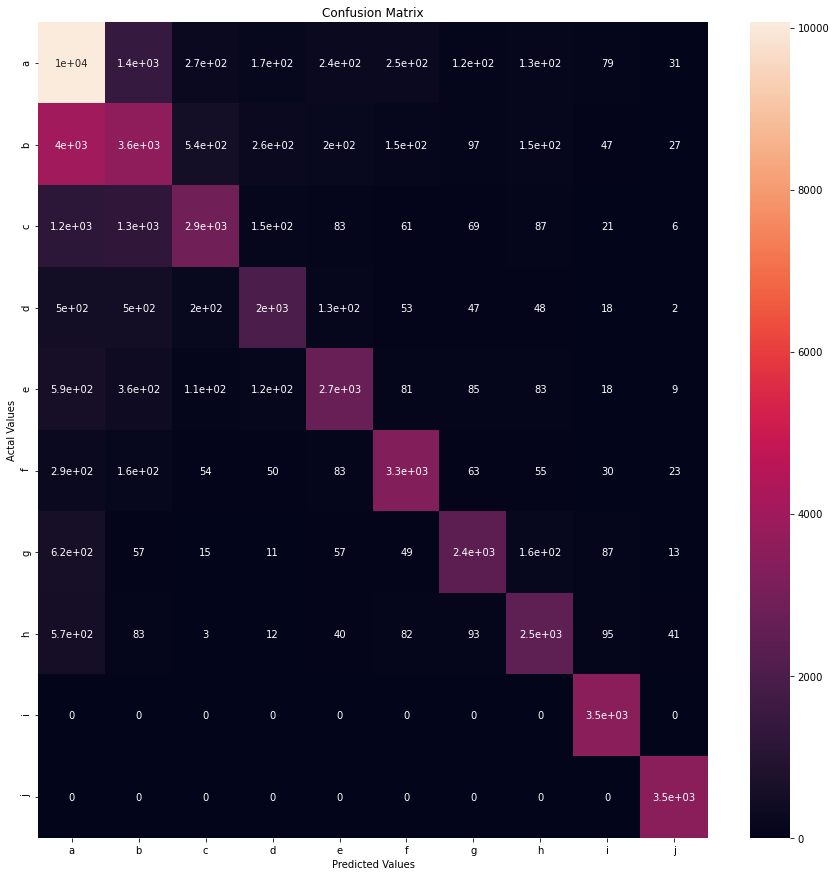

In [105]:
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['a','b','c','d','e','f','g','h','i','j'], 
                     columns = ['a','b','c','d','e','f','g','h','i','j'])

#Plotting the confusion matrix
plt.figure(figsize=(15,15))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [106]:
# confirming these are just array values to plot below
model10_unpickled.feature_importances_

array([0.00240641, 0.00190891, 0.00330339, ..., 0.00052054, 0.00045175,
       0.00400495], dtype=float32)

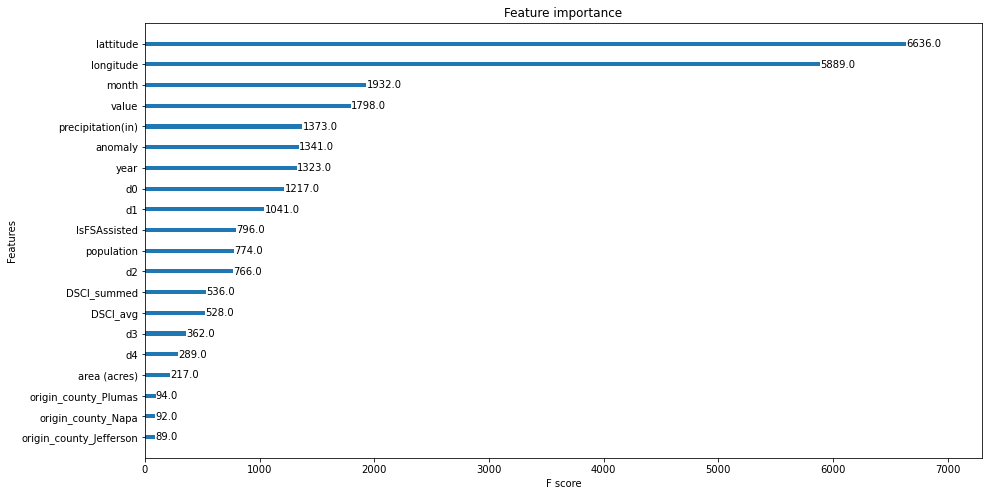

In [145]:
plt.rcParams["figure.figsize"] = (15, 8)
plot_importance(model10_unpickled, max_num_features=20,grid=False) # top 10 most important features
plt.show();

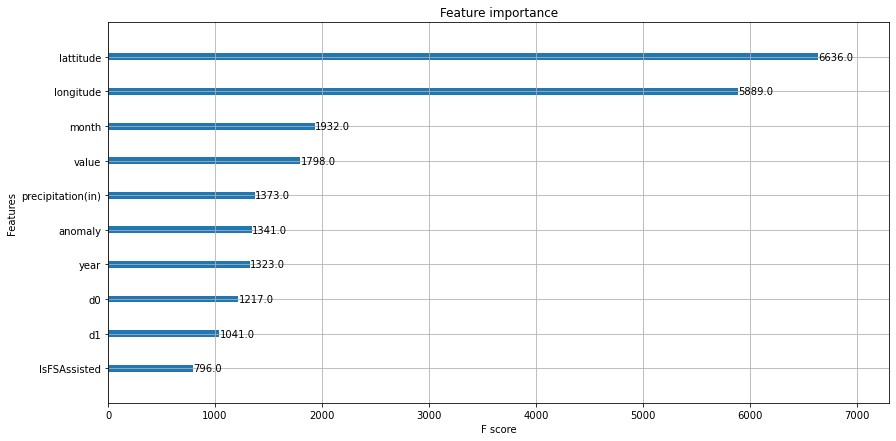

In [134]:
plt.rcParams["figure.figsize"] = (14, 7)

importance = plot_importance(model10_unpickled, max_num_features=10) # top 10 most important features
importance;
plt.savefig('../../Viz/readme_viz/importances.png',facecolor='white', edgecolor='none')  